In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_curve,f1_score,auc
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Set seed for reproduceable results
np.random.seed(500)
# Read in to Pandas DataFrame and drop the first row(which contained column names as I have assigned new names)
reviews = pd.read_csv(r"rt_reviews.csv", names = ['target', 'review'], encoding = 'latin-1')
reviews = reviews.iloc[1:]
reviews = reviews.iloc[:480000] # Choose num here

C:\Users\thoma\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
for i in range(reviews.shape[0]):
    #if(isinstance(reviews['target'].values[i],)):
    if(reviews['target'].values[i] == '0'):
        reviews['target'].values[i] = 0
    elif(reviews['target'].values[i] == '1'):
        reviews['target'].values[i] = 1
for i in range(reviews.shape[0]):
    if(isinstance(reviews['target'].values[i],str)):
        print("Caught: ",reviews['target'].values[i])
    if(reviews['target'].values[i] != 0 and reviews['target'].values[i] != 1):
        print("Error")

In [5]:

# Data is of shape(480000,2) The first column is the target, the second in the review

# Make data smaller for ease of implementation
reviews = reviews.iloc[:480000] # Choose num here

In [6]:
# Remove and row where either datafield is blank, no rows contained blank data so the shape remains 480000,2 
reviews.dropna(inplace = True)
reviews.shape

(480000, 2)

In [7]:
# Convert all text to lowercase so all words recognized the same 
reviews['review'] = [entry.lower() for entry in reviews['review']]

# Can now been seen to contain no capital letters
reviews.head()
#type(reviews)


,target,review
1,1,"manakamana doesn't answer any questions, yet ..."
2,1,wilfully offensive and powered by a chest-thu...
3,0,it would be difficult to imagine material mor...
4,0,despite the gusto its star brings to the role...
5,0,if there was a good idea at the core of this ...


In [8]:
# Tokenize each review: this process converts each review into a set of words. 
reviews['review'] = [word_tokenize(entry) for entry in reviews['review']]
type(reviews)

pandas.core.frame.DataFrame

In [9]:
reviews.head()

,target,review
1,1,"[manakamana, does, n't, answer, any, questions..."
2,1,"[wilfully, offensive, and, powered, by, a, che..."
3,0,"[it, would, be, difficult, to, imagine, materi..."
4,0,"[despite, the, gusto, its, star, brings, to, t..."
5,0,"[if, there, was, a, good, idea, at, the, core,..."


In [11]:
#DO NOT RUN

# Next steps are stemming/lemmenting which reduces words to their root so that words such as 'loving' and 'loved'
# both reduce to 'love'

# Creating tags so that lemmatizer can understand verbs from nouns from adjectives 
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(reviews['review']):
    index = index+1 # Index seems to off by one, this fixes it
    # Words that follow the rules will end up in this list
    Final_words = []
    
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
        reviews.loc[index, 'text_final'] = str(Final_words)

In [12]:
################ Unaltered Words ############

for index, entry in enumerate(reviews['review']):
    index = index + 1
    Final_words = []
        
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha() and wordnet.synsets(word):
            word_Final = word  #This is where a stemmer would go
            Final_words.append(word_Final)
        reviews.loc[index, 'unaltered_words'] = str(Final_words)   

In [13]:
reviews.shape

(480000, 3)

In [14]:
reviews.tail() 

,target,review,unaltered_words
479996,0,"[zemeckis, seems, unable, to, admit, that, the...","['seems', 'unable', 'admit', 'motion', 'captur..."
479997,1,"[movies, like, the, kids, are, all, right, --,...","['movies', 'like', 'kids', 'right', 'beautiful..."
479998,0,"[film-savvy, audiences, soon, will, catch, ont...","['audiences', 'soon', 'catch', 'attempts', 'ea..."
479999,1,"[an, odd, yet, enjoyable, film, .]","['odd', 'yet', 'enjoyable', 'film']"
480000,1,"[no, other, animation, studio, ,, even, our, b...","['animation', 'studio', 'even', 'beloved', 'qu..."


In [16]:
# Create Train and Test splits 
test_s = .15
train_x, test_x, train_y, test_y = model_selection.train_test_split(reviews['unaltered_words'], reviews['target'], test_size=test_s)

In [17]:
print("\ntrain_x Shape: ", train_x.shape)
print("\ntrain_y Shape: ", train_y.shape)
print("\ntest_x Shape: ", test_x.shape)
print("\ntest_y Shape: ", test_y.shape)
print(test_x)


train_x Shape:  (408000,)

train_y Shape:  (408000,)

test_x Shape:  (72000,)

test_y Shape:  (72000,)
360649    ['intimations', 'allusions', 'wicker', 'man', ...
285349    ['occasionally', 'stirring', 'peek', 'place', ...
59650     ['glum', 'muddy', 'muddled', 'gory', 'told', '...
178735    ['men', 'sets', 'puts', 'motion', 'premise', '...
84349     ['struggles', 'find', 'balance', 'contemporary...
                                ...                        
329586    ['bloated', 'crime', 'tome', 'meanders', 'far'...
143893    ['possible', 'see', 'crudely', 'assembled', 's...
469535    ['man', 'man', 'certainly', 'emit', 'quite', '...
89062     ['sincere', 'austere', 'intellectually', 'rigo...
298168    ['behind', 'candelabra', 'smear', 'job', 'reve...
Name: unaltered_words, Length: 72000, dtype: object


In [18]:
Encoder = LabelEncoder()
train_y = Encoder.fit_transform(train_y)
test_y = Encoder.fit_transform(test_y)

In [20]:
max_f = 480000
Tfidf_vect = TfidfVectorizer(max_features=max_f)
Tfidf_vect.fit(reviews['unaltered_words'])
train_x_Tfidf = Tfidf_vect.transform(train_x)
test_x_Tfidf = Tfidf_vect.transform(test_x)
#print(Tfidf_vect.vocabulary_)

In [21]:
print(train_x_Tfidf)

  (0, 45801)	0.39238223633546665
  (0, 39395)	0.6092874055425757
  (0, 37323)	0.581142094327209
  (0, 27332)	0.37024168357514853
  (1, 38330)	0.35093283377513174
  (1, 29175)	0.45756986201715516
  (1, 22621)	0.39528642847987117
  (1, 22611)	0.4191179416648708
  (1, 22576)	0.2850850503020472
  (1, 19445)	0.4640213909831402
  (1, 17902)	0.19742193594111576
  (2, 43084)	0.29545701870944535
  (2, 42342)	0.2976617421554046
  (2, 36810)	0.22038252506535663
  (2, 30084)	0.39070163127096746
  (2, 29723)	0.268742238964389
  (2, 25768)	0.4342130001275752
  (2, 25086)	0.20808090361868944
  (2, 24850)	0.19987200577523073
  (2, 22593)	0.25917026866811455
  (2, 16910)	0.2057035361081761
  (2, 10918)	0.22741455233301505
  (2, 7697)	0.1881274906284557
  (2, 1030)	0.28685206888167264
  (3, 46219)	0.17423381475704994
  :	:
  (407996, 47329)	0.46128372977414994
  (407996, 38902)	0.6119201617598373
  (407996, 13811)	0.4709986239071192
  (407996, 12434)	0.43695690011151395
  (407997, 38994)	0.3182700186921

In [26]:
# First Attempt at classifier is Naive Bays 
nbm = naive_bayes.MultinomialNB()
nbm.fit(train_x_Tfidf, train_y)

#Bernoulli Naive Bayes
nbb = naive_bayes.BernoulliNB()
nbb.fit(train_x_Tfidf, train_y)

# predict the target on validation data
pred_nbm = nbm.predict(test_x_Tfidf)
pred_nbb = nbb.predict(test_x_Tfidf)

# output accuracy just to show it works
print("NB Multinomial: Accuracy: ", accuracy_score(pred_nbm, test_y))
print("NB Bernoulli: Accuracy: ", accuracy_score(pred_nbb, test_y))

#svm = SVC(probability=True)
#svm.fit(train_x_Tfidf, train_y)
#pred_svm = svm.predict(test_x_Tfidf)
#print("SVM: Accuracy: ", accuracy_score(pred_svm, test_y))


NB Multinomial: Accuracy:  0.7947638888888889
NB Bernoulli: Accuracy:  0.7948194444444444


              precision    recall  f1-score   support

           0       0.79      0.80      0.80     35977
           1       0.80      0.79      0.79     36023

    accuracy                           0.79     72000
   macro avg       0.79      0.79      0.79     72000
weighted avg       0.79      0.79      0.79     72000

              precision    recall  f1-score   support

           0       0.78      0.81      0.80     35977
           1       0.81      0.78      0.79     36023

    accuracy                           0.79     72000
   macro avg       0.80      0.79      0.79     72000
weighted avg       0.80      0.79      0.79     72000

Test Split:  0.15
Max Features:  480000
Naive-Bayes-Multinomial: f1=0.794
Accuracy:  0.7947638888888889
Naive-Bayes-Bernoulli: f1=0.791
Accuracy:  0.7948194444444444


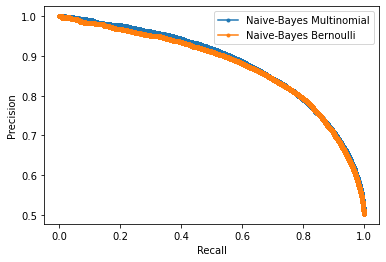

In [27]:
#Analysis

#Predict Probability
nbm_probs = nbm.predict_proba(test_x_Tfidf)
nbm_probs = nbm_probs[:,1]
nbb_probs = nbb.predict_proba(test_x_Tfidf)
nbb_probs = nbb_probs[:,1]
#svm_probs = svm.predict_proba(test_x_Tfidf)
#svm_probs = svm_probs[:,1]

#Classification Report
print(classification_report(test_y, pred_nbm, labels=[0,1]))
print(classification_report(test_y, pred_nbb, labels=[0,1]))
#print(classification_report(test_y, pred_svm, labels=[0,1]))

#Calculate precision-recall
precision_nbm, recall_nbm, thresholds_nbm = precision_recall_curve(test_y, nbm_probs)
precision_nbb, recall_nbb, thresholds_nbb = precision_recall_curve(test_y, nbb_probs)
#precision_svm, recall_svm, thresholds_svm = precision_recall_curve(test_y, svm_probs)

#Calculate F1
f1_nbm = f1_score(test_y, pred_nbm)
f1_nbb = f1_score(test_y, pred_nbb)
#f1_svm = f1_score(test_y, pred_svm)

#Calculate precision recal auc
# auc_nb = auc(recall_nb, precision_nb)
# auc_svm = auc(recall_svm, precision_svm)

# summarize scores
print("Test Split: ", test_s)
print("Max Features: ", max_f)
print('Naive-Bayes-Multinomial: f1=%.3f' % (f1_nbm))
print("Accuracy: ", accuracy_score(pred_nbm, test_y))
print('Naive-Bayes-Bernoulli: f1=%.3f' % (f1_nbb))
print("Accuracy: ", accuracy_score(pred_nbb, test_y))
#print('Support Vector Machine: f1=%.3f' % (f1_svm))
#print("Accuracy: ", accuracy_score(pred_svm, test_y))


# plot the precision-recall curves
no_skill = len(test_y[test_y==1]) / len(test_y)
pyplot.plot(recall_nbm, precision_nbm, marker='.', label='Naive-Bayes Multinomial')
pyplot.plot(recall_nbb, precision_nbb, marker='.', label='Naive-Bayes Bernoulli')
#pyplot.plot(recall_svm, precision_svm, marker='.', label='SVM')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

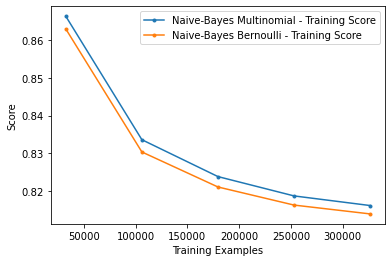

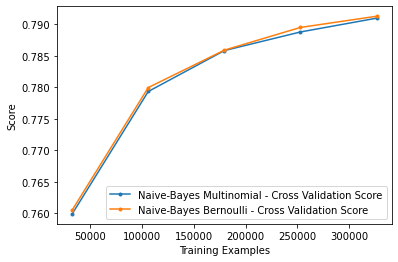

In [28]:
#Learning curve
#svm_train_sizes, svm_train_scores, svm_valid_scores = learning_curve(SVC(probability=True), train_x_Tfidf, train_y,  cv=5)
nbm_train_sizes, nbm_train_scores, nbm_valid_scores = learning_curve(naive_bayes.MultinomialNB(), train_x_Tfidf, train_y,  cv=5)
nbb_train_sizes, nbb_train_scores, nbb_valid_scores = learning_curve(naive_bayes.BernoulliNB(), train_x_Tfidf, train_y,  cv=5)

nbm_valid_scores = np.mean(nbm_valid_scores, axis=1)
nbm_train_scores = np.mean(nbm_train_scores, axis=1)
nbb_valid_scores = np.mean(nbb_valid_scores, axis=1)
nbb_train_scores = np.mean(nbb_train_scores, axis=1)
#svm_valid_scores = np.mean(svm_valid_scores, axis=1)
#svm_train_scores = np.mean(svm_train_scores, axis=1)

pyplot.plot(nbm_train_sizes, nbm_train_scores, marker='.', label='Naive-Bayes Multinomial - Training Score')
pyplot.plot(nbb_train_sizes, nbb_train_scores, marker='.', label='Naive-Bayes Bernoulli - Training Score')
#pyplot.plot(svm_train_sizes, svm_train_scores, marker='.', label='SVM - Training Score')

pyplot.xlabel('Training Examples')
pyplot.ylabel('Score')
pyplot.legend()

# show the plot
pyplot.show()

pyplot.plot(nbm_train_sizes, nbm_valid_scores, marker='.', label='Naive-Bayes Multinomial - Cross Validation Score')
pyplot.plot(nbb_train_sizes, nbb_valid_scores, marker='.', label='Naive-Bayes Bernoulli - Cross Validation Score')
#pyplot.plot(svm_train_sizes, svm_valid_scores, marker='.', label='SVM - Cross Validation Score')
pyplot.xlabel('Training Examples')
pyplot.ylabel('Score')
pyplot.legend()

# show the plot
pyplot.show()